# How to Calibrate TopoFlow with Remote Sensing Data

## PLEASE NOTE:  &nbsp; This notebook is not quite finished yet.

#### Table of Contents

1.  <a href="#intro_H">Introduction</a> <br>
2.  <a href="#install_H">How to Install the TopoFlow Python Package</a> <br>
3.  <a href="#baro_H">Baro River Basin, Gambella, Ethiopia</a> <br>
4.  <a href="#guess_H">Calibration vs. Best-Guess Parameters</a> <br>
5.  <a href="#cost_fcn_H">Defining a Specialized Cost Function</a> <br>
6.  <a href="#rs_data_H">Remotely-Sensed River Width Data for Baro River at Gambela</a> <br>
7.  <a href="#calibrate_H">TopoFlow Calibration for Baro River at Gambela</a> <br>
8.  <a href="#conclusions_H">Conclusions </a> <br> 
9.  <a href="#notebooks_H">Other Jupyter Notebooks for TopoFlow 3.6 </a> <br>
10. <a href="#refs_H">Key References for TopoFlow</a> <br>
11. <a href="#setup_H">Appendix 1: Installing TopoFlow in a conda Environment</a>

<!-- Hyperlink IDs must be unique to work in Jupyter Lab when
there are multiple notebooks open. Hence the trailing letter. -->

## Introduction  <a id="intro_H"></a>

This notebook shows a model calibration exercise for the TopoFlow 3.6 hydrologic model that uses observed river width measurements vs. time derived from remote sensing and compares them to simulated river discharge values using an innovative, new approach.  Model calibration typically uses observed and simulated values for the same variable, which is usually <b>river discharge</b>. However, this new approach uses observed and simulated values for <b>two different variables</b>.  The cost function in this case is based on the <b>Spearman rank correlation</b> of the two variables.  Details of the new method are explained and then applied, using the <b>calibrate</b> module that is included among the TopoFlow utilities in <b>topoflow/utils</b>.  

Model calibration is computationally expensive and is best performed on supercomputers with specialized toolkits such as [<b>DAKOTA</b>](https://dakota.sandia.gov/) from DOE's Sandia Labs.  It basically involves performing a very large number of model runs with different combinations of the adjustable parameters to find the set of parameters that results in the closest match between observations of some variable and model predictions for the same variable.  The goal of this notebook is to show how calibration works using a grealy <b>simplified example</b> where only one model parameter is considered to be adjustable.  A future notebook will illustrate a more complex and realistic example of model calibration for TopoFlow.


## How to Install the TopoFlow Python Package  <a id="install_H"></a>

Before you can run the code in this notebook, you will need to install the TopoFlow 3.6 Python package.

Detailed instructions and background information for how to install TopoFlow in a conda environment are given in
<a href="#setup_H"><b>Appendix 1:  Installing TopoFlow in a conda Environment</b></a>.

## Baro River Basin, Gambela, Ethiopia  <a id="baro_H"></a>

The 
[<b>Baro River</b>](https://en.wikipedia.org/wiki/Baro_River)
is a large tributary of the
[<b>Sobat River</b>](https://en.wikipedia.org/wiki/Sobat_River)
that flows westward from the
[<b>Ethiopian Highlands</b>](https://en.wikipedia.org/wiki/Ethiopian_Highlands)
and lies partly within both the
[<b>Oromia</b>](https://en.wikipedia.org/wiki/Oromia_Region)
and
[<b>Gambela</b>](https://en.wikipedia.org/wiki/Gambela_Region)
regions.  It is about 150 meters wide as it passes through the
[<b>town of Gambela</b>](https://en.wikipedia.org/wiki/Gambela,_Ethiopia),
and drains a contributing area of over 41,000 square kilometers.

<table> <tr>
  <td> <img src="attachment:image.png" width="70%">
</tr> </table>

<b>Figure.</b> A color, shaded-relief image of the Baro River basin, in Ethiopia, where red is high elevation and blue is lower elevation.  Black lines show the river network and the white polygon is the watershed boundary.

## Calibration vs. Best-Guess Parameters  <a id="guess_H"></a>

Model <b>calibration</b> is one commonly-used method for
[<b>parameter estimation</b>](https://en.wikipedia.org/wiki/Estimation_theory)
(PE).  This method requires the use of a
[<b>cost function</b>](https://en.wikipedia.org/wiki/Loss_function)
that compares the <b>observed</b> or measured values of some variable to the values that are <b>predicted</b> by a model for that same variable.  It is important to understand that this method of parameter estimation <b>requires</b> observational data;  it cannot be used when observational data is unavailable.  For most of the river basins in the world, and especially on the African continent, observational data is only available for a relatively small number of river basins;  typically just the largest basins.

For hydrologic models, it is common to use a time series of
[<b>river discharge</b>](https://en.wikipedia.org/wiki/Discharge_(hydrology))
(which has units of volume per time), as the variable that is both observed and predicted, at some river basin outlet where there is a gauging station.  The modeler decides which model parameters will be held fixed and which will be allowed to be set by this method, and the model is then run many, many times, each time using a different set of possible parameter values (over allowed ranges) and each time computing the value of the cost function.  This is an
[<b>optimization problem</b>](https://en.wikipedia.org/wiki/Optimization_problem),
where one seeks the global minimum of the cost function over the model's
[<b>parameter space</b>](https://en.wikipedia.org/wiki/Parameter_space).
The cost function is often simply an
[<b>L2 norm</b>](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm)
(i.e. least squares difference) that measures how close the model predictions are to the observations.  When finished, the model's adjustable parameters are set to those of the model run that minimized the cost function.  Unfortunately, it can happen that many different sets of parameters will minimize the cost function equally well, and this problem is called
[<b>equifinality</b>](https://en.wikipedia.org/wiki/Equifinality).

Since model calibration utilizes observational data, measurement errors of any kind can be a problem.  Also, a model must be recalibrated when it is applied to a different location (e.g. another river basin).  And due to the likely
[<b>nonstationarity</b>](https://en.wikipedia.org/wiki/Stationary_process)
of weather variables, it may also need to be recalibrated when it is applied to a different time period or to any circumstances that were not reflected in the observational data (such as a large flood event).

In the common case where observational data is not available, a domain expert will gather as much information about the region (and scenario) of interest as possible, from any available source (e.g. papers, books, websites, global databases, personal communication, etc.), and combine this with his or her understanding of the underlying physics (expert knowledge) and a few assumptions to make <b>best guesses</b> for the values of adjustable parameters.  Neither calibration nor this method is foolproof, so model predictions always have uncertainty.  Note that even a perfect model (if that were possible) will give incorrect and even nonsensical results if its parameters are set incorrectly.

A closely related topic is
[<b>model sensitivity analysis</b>](https://en.wikipedia.org/wiki/Sensitivity_analysis).
As with model calibration, a model sensitivity study requires a model to be run many, many times with different parameter settings.  However, the goal in this case is to determine the degree to which the model predictions (i.e. the numerical values of the output variables) are <b>sensitive</b> to changes in any given parameter.  Physically-based models, where each parameter represents some important aspect of the physics, can be sensitive to many of their parameters.  In some cases a model may even become chaotic or exhibit a discontinuous jump in its predicted values even after a parameter is changed by only a very tiny amount.

## Defining a Specialized Cost Function  <a id="cost_fcn_H"></a>

In another Jupyter notebook, called
[<b>TopoFlow_Calibration_Gauge_Data.ipynb</b>](https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Calibration_Gauge_Data.ipynb),
in the section titled: <b>Defining the Cost Function</b>, the typical method of defining a cost function with a
[<b>least squares</b>](https://en.wikipedia.org/wiki/Least_squares) metric (L2 norm) was explained.  In that case, it was the <b>same</b> variable, <b>river discharge</b> that was being both <b>observed</b> and <b>simulated</b>, and the cost function was measuring the degree to which simulated values agreed with observed values.
In this notebook, we face a more complex situation so that a specialized cost function is necessary.  The observed variable in this case is a <b>remotely-sensed time series of river widths</b> at carefully selected grid cells where the width varies significantly over time.  But the simulated variable will again be a time series of <b>simulated river discharge</b>, for reasons we explain in this section.

In straight sections of river channels, it is usually the case that the river width varies only very slightly over time.  This is because <b>overbank flow</b> (i.e. flooding), where a river flows outside of its banks, is a rare event, occurring perhaps only once every 3 years or so.   The rest of the time the river stays within its banks and gets deeper, but not much wider.  (Note:  Remote sensing of river depth is usually not possible, except in rare cases where the water is very clear.)   This can easily be verified by viewing rivers in Google Earth, where river banks are often clearly marked by large trees.  By contrast, the width may be observed to change by a significant amount at certain locations, such as in river bends, where the channel cross-section is more like a right triangle instead of a trapezoid (with flat bottom).

As a spatial, hydrologic model, TopoFlow assumes that all channels are <b>prismatic</b>, with
symmetric, [<b>trapezoidal cross-sections</b>](https://en.wikipedia.org/wiki/Trapezoid).
(But they may have a sinuosity greater than 1.)
This means, that their <b>simulated river widths</b> vary only slightly over time, except when overbank flow occurs, similar to straight channels in real river networks.  So while we could attempt to calibrate TopoFlow with a cost function that compares <b>observed</b> and <b>simulated</b> river widths, we expect the "signal" to be weak and results to be poor.  Keep in mind that river width may change by only 10\% or so during a large flow event, while the river discharge itself may change by a factor of 10 or more.  So river discharge provides a much stronger signal for the purpose of calibration.  Also, TopoFlow (and most hydrologic models) conserve the mass of water, which directly constrains the simulated river discharge.  By contrast, simulated river width depends on channel bankfull width, which is a poorly-constrained input to the model.  Since basin-wide observations of bankfull width are usually unavailable, it is estimated in TopoFlow using an empirical, power-law function of total contributing area (TCA).

These considerations lead us to seek a novel cost function that is built using <b>observed river width</b> over time (from remote sensing) and <b>simulated river discharge</b> over time, at the same location.  That is, we want to build a cost function where the observed and simulated variables are different.  The key to doing this is to start from the following assumption on how the two variables are related.<br>

<b>Assumption:</b> River width, w, is a
[<b>monotonically increasing</b>](https://en.wikipedia.org/wiki/Monotonic_function)
function of river discharge, Q, at a fixed location.<br>

i.e. When the discharge increases, the width increases.  While rare exceptions may exist, this is a pretty safe assumption.  A consequence of this is that peaks and troughs in a time series of river width should line up with the peaks and troughs in a corresponding time series of river discharge, at the same location.

In statistics, there is a well-known method for testing the hypothesis that one variable varies monotonically with another variable, known as
[<b>Spearman's rank correlation coefficient</b>](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).
This is a [<b>nonparametric test</b>](https://en.wikipedia.org/wiki/Nonparametric_statistics),
meaning that no assumptions on the distributions of the variables are required.
The test instead uses 
[<b>rank statistics</b>](https://en.wikipedia.org/wiki/Rank_correlation) based on the
[<b>rankings</b>](https://en.wikipedia.org/wiki/Ranking) of two variables.
Given two 1D arrays (e.g. time series), $X$ and $Y$, and denoting this coefficient as $r_{XY}$, we have:

$r_{XY} = 1 \,\,\,$, if $Y$ is a monotonically <b>increasing</b> function of $X$, <br>
$r_{XY} = 0 \,\,\,$, if $Y$ and $X$ are uncorrelated, and <br>
$r_{XY} = -1$,     if $Y$ is a monotonicaly <b>decreasing</b> function of $X$.

However, a
[<b>correlation coefficient</b>](https://en.wikipedia.org/wiki/Correlation_coefficient) does not have the
necessary properties to serve as a norm or
[<b>distance metric</b>](https://en.wikipedia.org/wiki/Metric_space), and the
[<b>cost function</b>](https://en.wikipedia.org/wiki/Loss_function)
we use for calibration should be a metric.  We can rectify this by defining our cost function to be:

$$ \large{
d \left( \boldsymbol{Y}_{obs}, \boldsymbol{X}_{sim} \right) =
{\textstyle \frac{1}{2}} \left( 1 - r_{XY} \right).
}$$

where:<br>
$Y_{obs}$ is a vector of observed values with components $y_k^{\, (obs)}$,<br>
$X_{sim}$ is a vector of simulated values with components $x_k^{\, (sim)}$.<br>

This returns values between 0 and 1, inclusive.  It returns $0$ whenever $Y$ is a monotonically increasing function of $X$, and returns $1$ whenever $Y$ is a monotonically decreasing function of $X$.  This also has the property that $d(X,X) = 0$, as required for metrics.

For our application, $Y_{obs} = w$ (river widths) and $X_{sim} = Q$ (river discharges).

While not indicated explicitly in the notation above, it is understood that the vector of simulated values, $X_{sim}$, is a function of the values of all of the model's adjustable parameters, sometimes called <b>control parameters</b> or <b>design parameters</b>.

### Known Limitations

It is important to understand that this cost function has limitations.  While it is sensitive to the timing of X and Y (and penalizes any time lag), it does not help to ensure that the <b>magnitude</b> of the simulated discharge is correct. To see this, notice that $Y = c \cdot X \,\,$ is a monotonically increasing function of $X$ for any $c > 0$ (e.g. $c=1000$) and would therefore have $d(X,Y) = 0$.  Similarly, $Y = e^X$ is also monotonically increasing, and has $d(X,Y) = 0$, even though it yields extremely different magnitudes.  Given other information, the cost function could be modified to mitigate this limitation.

Another limitation is that simulated river discharge, $X$, is strongly dependent on both the magnitude
(i.e. intensity, volume flux, or mass flux) and
[<b>space-time pattern</b>](https://en.wikipedia.org/wiki/Rain#Patterns)
of rainfall.  Problems with the rainfall data, even if the total volume is correct, can result in a time series of river discharge that does not align with the remotely-sensed river widths.  Known issues with satellite-derived rainfall products are discussed in the notebook:
[<b>TopoFlow_Rainfall_Inputs.ipynb</b>](https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Rainfall_Inputs.ipynb).

### Footnotes

(1) This cost function has been implemented in <b>topoflow/utils/calibrate.py</b> as a function called: <b>spearman_metric</b>.

(2) In Python, the Spearman rank correlation coefficient can be computed with
[<b>scipy.stats.spearmanr</b>](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html).

(3) Another well-known, nonparametric test based on rankings is the
[<b>Kolmogorov-Smirnov test</b>](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

(4) For the metric (and metric space) defined above, the
[<b>unit circle</b>](https://en.wikipedia.org/wiki/Unit_circle)
centered on a given vector of values, $X$, is the set of all monotonically decreasing functions of $X$.
<br>


## Remotely-Sensed River Width Data for Baro River at Gambela  <a id="rs_data_H"></a>

A subset of the
[<b>MINT Project</b>](http://mint-project.info/) team,
led by Dr. Vipin Kumar, has developed a methodology for identifying the pixels in a remotely-sensed image that are covered with water.  The procedure involves <b>two different spatial resolutions</b>: one where grid cells are much smaller than the width of a river of interest, and another where grid cells are several times larger than this river width.  The first one corresponds to the satellite imagery, and the second one corresponds to the computational grid of a hydrologic model.  Counting the number of smaller grid cells in one of the larger grid cells that are covered by water provides an indication of whether the river is flowing within its banks (with low or high flow), or flowing outside of its banks (flooding).  When a large river is flowing within its banks, this number of grid cells doesn't change very much.  However, when <b>overbank flow</b> occurs (i.e. flooding), an area several times wider than the river can be inundated with water, causing a dramatic jump in this number of grid cells.  It is important to realize, however, that rivers typically flow within their banks, and overbank flow may only occur every few years.  (Every 3 or 4 years is typical.)

The following figure shows the percentage of area that is covered by water for a grid cell that is several times wider than the Baro River near the town of Gambela.  It spans the period from 2015-10-3 to 2020-05-29 and has 139 measurements over this period, for an average of about one measurement every 12 days.  Around 2016-06-19, the value jumps from 0.3174 to 0.7752.  Around 2016-11-16, it drops from 0.6613 back down to 0.3179.  It appears that a flood event in mid-June of 2016 resulted in overbank flow and a filling of the wetland areas that border the Baro River near Gambela.  The water apparently persisted until mid-November of 2016.    


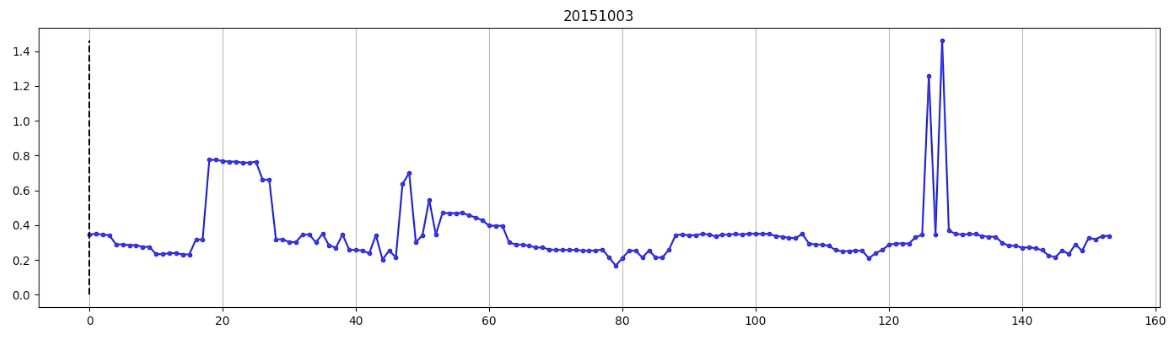

We will be running TopoFlow for the 3-year period of 2015-10-01 to 2018-10-01, and using the first 3 year of this observational record as the "observed values" for calibrating TopoFlow

## TopoFlow Model Run for Baro River at Gambela  <a id="test_run_H"></a>

Before starting the calibration exercise, which requires multiple model runs, each taking about 15 minutes on my new MacBook Pro, we perform a run with some "best-guess" parameters to get an idea of what to expect.

In [1]:
from topoflow import main
import os, os.path

cfg_prefix  = 'Test1'
case_prefix = 'Test1'
home_dir    = os.path.expanduser("~")
basin_dir   = home_dir + '/TF_Tests3/Baro-Gam_60sec/'
print('Your Home directory =', home_dir)
print('Basin directory     =', basin_dir)

time_interp_method = 'None'
# time_interp_method = 'Linear'

Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
Your Home directory = /Users/peckhams
Basin directory     = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/


In [2]:
cfg_dir = basin_dir + 'Test1_2015-10_to_2018-10_GLDAS_Bilinear_cfg/'
print('CFG directory =', cfg_dir)

main.run_model(cfg_prefix=cfg_prefix, cfg_directory=cfg_dir,
               time_interp_method=time_interp_method)

CFG directory = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/Test1_2015-10_to_2018-10_GLDAS_Bilinear_cfg/
EMELI: Reading info from provider_file:
    /Users/peckhams/TF_Tests3/Baro-Gam_60sec/Test1_2015-10_to_2018-10_GLDAS_Bilinear_cfg/Test1_providers.txt
EMELI: Reading info from comp_repo_file:
    /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/component_repository.xml

EMELI: Instantiated component: tf_meteorology
EMELI: Instantiated component: tf_diversions_fraction_method
EMELI: Instantiated component: tf_channels_kin_wave
EMELI: Instantiated component: tf_snow_degree_day
EMELI: Instantiated component: tf_satzone_darcy_layers
EMELI: Instantiated component: tf_evap_priestley_taylor
EMELI: Instantiated component: tf_infil_richards_1d
EMELI: Instantiated component: tf_ice_gc2d
EMELI: Instantiated component: topoflow_driver
Driver component name = topoflow_driver
 
Meteorology component: Initializing...
Computing pixel area grid...
Reading config file into component state.
In met_b

### Display the Predicted Hydrograph

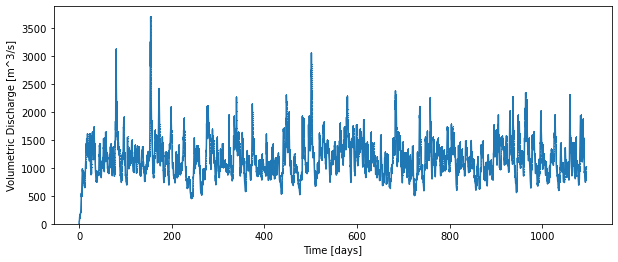

In [3]:
from topoflow.utils import visualize as tfvis
output_dir = basin_dir + 'Test1_2015-10_to_2018-10_GLDAS_Bilinear_OUT/'
os.chdir(output_dir)
nc_file = case_prefix + '_0D-Q.nc'
tfvis.plot_time_series(nc_file, output_dir=output_dir, var_index=1,
                       marker=',', REPORT=False, xsize=10, ysize=4)

If we compare this figure to the previous one with remote-sensing observations, we see that the highest peaks of simulated river discharge have a similar spacing to the peaks in the observations.  However, the river discharge peaks have a very short duration and the timing is off.  In addition, this time series has a much higher temporal resolution, with simulated values for every 50 minutes. <br>

The bankfull depth of the Baro River near Gambela is estimated to be about 8 meters based on an online literature search (but we were unable to obtain actual measurements).  Based on the next figure, which shows predicted river depths, this value appears to be consistent with the idea that the peaks in the remote-sensing data correspond to flooding events that "recharge" the wetlands. 

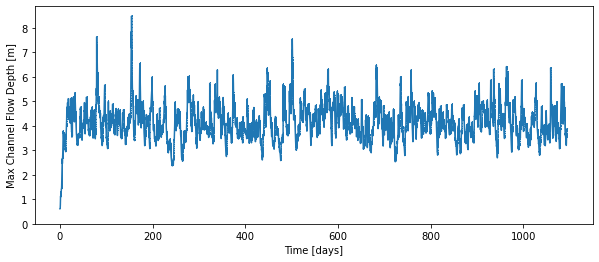

In [4]:
from topoflow.utils import visualize as tfvis
output_dir = basin_dir + 'Test1_2015-10_to_2018-10_GLDAS_Bilinear_OUT/'
os.chdir(output_dir)
nc_file = case_prefix + '_0D-d.nc'
tfvis.plot_time_series(nc_file, output_dir=output_dir, var_index=1,
                       marker=',', REPORT=False, xsize=10, ysize=4)

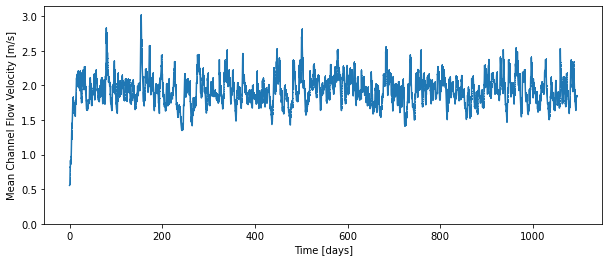

In [5]:
from topoflow.utils import visualize as tfvis
output_dir = basin_dir + 'Test1_2015-10_to_2018-10_GLDAS_Bilinear_OUT/'
os.chdir(output_dir)
nc_file = case_prefix + '_0D-u.nc'
tfvis.plot_time_series(nc_file, output_dir=output_dir, var_index=1,
                       marker=',', REPORT=False, xsize=10, ysize=4)

## TopoFlow Calibration for Baro River at Gambela  <a id="calibrate_H"></a>

This is just a simple calibration where we only allow one parameter to vary, for purposes of demonstration.  The procedure is to perform many model runs where we vary that parameter over its allowed range (i.e. we sample the parameter space) and for each run we compute a cost function that compares predictions to observations.  Finally, we save the value of the parameter that minimizes the cost function.

Here we use a TopoFlow utility in <b>topoflow/utils</b> called <b>calibrate.py</b>.

<b>Note:</b> For a full-fledged calibration exercise, where more parameters would be allowed to vary, the best approach is to use a sophisticated toolkit such as
[<b>DAKOTA</b>](https://dakota.sandia.gov/), developed over decades by DOE's Sandia National Lab.
DAKOTA can more rapidly perform a large ensemble of model runs by automatically taking advantage of parallel processing on a supercomputer or cluster.  Details for how to calibrate TopoFlow with DAKOTA will be provided in a future notebook.  In addition to its computational speed, DAKOTA offers an extensive collection of tools and algorithms that go far beyond optimization problems (like model calibration), to encompass all types of <b>uncertainty quantification</b> and <b>sensitivity analysis</b>.

We begin by importing the <b>calibrate</b> module.  This module reads required information about the observed and predicted time series from a configuration (CFG) file called <b>calibrate.cfg</b>.  Note that simulated values from TopoFlow will be stored with a fixed time interval between values (i.e. regular spacing in time), but the observed values are often stored with an irregular time interval.  Because of this observed values often need to be <b>regularized</b>, or interpolated to the same times associated with the simulated values before computing the cost function.  Also, observed times (and sometimes dates), may use different formats such as "hhmm", "datetime" (e.g. 2015-10-01 12:34:56), or "float".  The <b>calibrate</b> module automatically deals with all of these issues.


In [1]:
from topoflow.utils import calibrate

#---------------------------------------------
# Create an instance of the calibrator class
#---------------------------------------------
basin_dir = '/Users/peckhams/TF_Tests3/Baro-Gam_60sec/'
cfg_file  = basin_dir + 'Test1_2015-10_to_2018-10_GLDAS_Bilinear_cfg/calibrate.cfg'
cal = calibrate.calibrator(cfg_file=cfg_file)
cal.print_file_info()
# cal.get_simulated_values( SILENT=False )
# cal.get_observed_values( SILENT=False )


Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
In print_file_info():
  cfg_prefix   = Test1
  site_prefix  = Baro-Gam_60sec
  examples_dir = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/
  basin_dir    = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/
  topo_dir     = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/__topo/
  output_dir   = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/Test1_2015-10_to_2018-10_GLDAS_Bilinear_OUT/
  cfg_dir      = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/Test1_2015-10_to_2018-10_GLDAS_Bilinear_cfg/
  home_dir     = /Users/peckhams
  obs_dir      = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/__observations/
  sim_dir      = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/Test1_2015-10_to_2018-10_GLDAS_Bilinear_OUT/



In [4]:
print(cal.sim_times[0:5])
print(cal.sim_times.max())
print(cal.obs_times[0:20])
print(cal.obs_times[600:620])
print(cal.obs_times[-20:])
print(cal.cost_fcn)
print(cal.sim_times.size)
print(cal.obs_times.size)

[  0.  50. 100. 150. 200.]
1576750.0
['2015-10-01 00:00:00' '2015-10-01 00:50:00' '2015-10-01 01:40:00'
 '2015-10-01 02:30:00' '2015-10-01 03:20:00' '2015-10-01 04:10:00'
 '2015-10-01 05:00:00' '2015-10-01 05:50:00' '2015-10-01 06:40:00'
 '2015-10-01 07:30:00' '2015-10-01 08:20:00' '2015-10-01 09:10:00'
 '2015-10-01 10:00:00' '2015-10-01 10:50:00' '2015-10-01 11:40:00'
 '2015-10-01 12:30:00' '2015-10-01 13:20:00' '2015-10-01 14:10:00'
 '2015-10-01 15:00:00' '2015-10-01 15:50:00']
['2015-10-21 20:00:00' '2015-10-21 20:50:00' '2015-10-21 21:40:00'
 '2015-10-21 22:30:00' '2015-10-21 23:20:00' '2015-10-22 00:10:00'
 '2015-10-22 01:00:00' '2015-10-22 01:50:00' '2015-10-22 02:40:00'
 '2015-10-22 03:30:00' '2015-10-22 04:20:00' '2015-10-22 05:10:00'
 '2015-10-22 06:00:00' '2015-10-22 06:50:00' '2015-10-22 07:40:00'
 '2015-10-22 08:30:00' '2015-10-22 09:20:00' '2015-10-22 10:10:00'
 '2015-10-22 11:00:00' '2015-10-22 11:50:00']
['2018-09-29 07:20:00' '2018-09-29 08:10:00' '2018-09-29 09:00:00'


0.5437686157261529


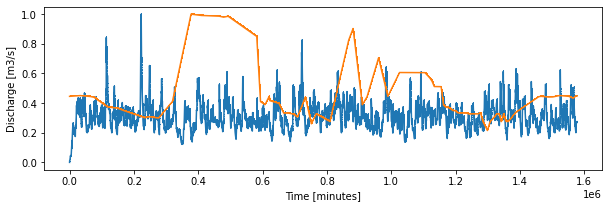

In [5]:
Y_obs = cal.obs_values
Y_sim = cal.sim_values
n_obs = Y_obs.size   #  ndarrays
n_sim = Y_sim.size
if (n_obs < n_sim):
    Y_sim = Y_sim[0:n_obs]
else:
    Y_obs = Y_obs[0:n_sim]
cost = calibrate.spearman_metric(Y_obs, Y_sim) 
print( cost )
cal.plot_hydrographs(normalize=True, marker=',')

Now, we choose a <b>calibration variable</b>, <i>cal_var</i>, and perform the calibration exercise. The four calibration variables shown here are used as inputs to a function in TopoFlow's <b>parameterize</b> module that generates an input grid of channel widths or Manning's n roughness values.  These grids have the same dimensions as the DEM, and are estimates computed as power-law functions of the <b>total contributing area</b> (TCA) grid.  The chosen calibration variable is varied over a set range of possible values, and for each of those values a new input grid is created and a new model run is performed.  After each model run, the cost function is evaluated.  Various 1D arrays are saved in the state of the calibrator object, namely
<blockquote> <ul>
<li> cal.obs_times   &nbsp; (in minutes)
<li> cal.obs_values  &nbsp; (observed values)
<li> cal.sim_times   &nbsp; (in minutes)
<li> cal.sim_values  &nbsp; (simulated values)
<li> cal.params      &nbsp; (the set of parameter values used)
<li> cal.costs       &nbsp; (the cost associated with each parameter value used)
<li> cal.best_param  &nbsp; (the parameter value with the lowest cost)
</ul> </blockquote>
Setting the <b>PLOT</b> keyword to True generates a plot after each model run to compare the observed discharge values to the values that are predicted for the given parameter settings.  The orange curve shows the observed values and the blue curve has the predicted values for a given model run.  These plots are created using TopoFlow's <b>visualize</b> module, in topoflow/utils/visualize.pro. <br> <br>

Keep in mind that we could get a better fit and lower cost by allowing multiple parameters to vary over their allowed ranges.  That exercise will be added to this notebook soon.

Working...
   param = 0.04
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
D8 flow code = 0 for 576 cells.
Number of cells on 4 DEM edges = 522

Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
target file = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/Test1_2015-10_to_2018-10_GLDAS_Bilinear_OUT/Test1_0D-Q.txt


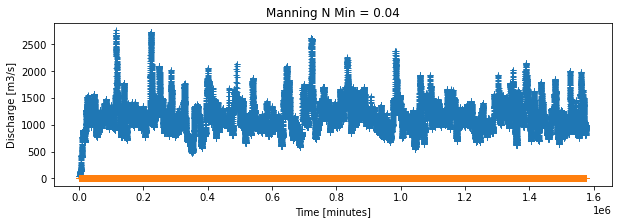

   param = 0.05
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
D8 flow code = 0 for 576 cells.
Number of cells on 4 DEM edges = 522

Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
Computing pixel area grid...
target file = /Users/peckhams/TF_Tests3/Baro-Gam_60sec/Test1_2015-10_to_2018-10_GLDAS_Bilinear_OUT/Test1_0D-Q_1.txt


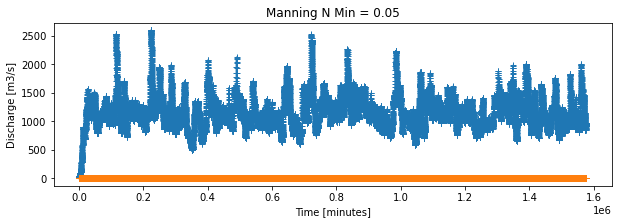

In [2]:
cal.calibrate( cal_var='manning_n_min', PLOT=True, SILENT=True )
# cal.calibrate( cal_var='manning_n_max', PLOT=True, SILENT=True )

# cal.calibrate( cal_var='channel_width_power', PLOT=True, SILENT=True )
# cal.calibrate( cal_var='channel_width_max', PLOT=True, SILENT=True )

### Print out the parameter values and their associated costs

For the case where the adjustable parameter is <b>manning_n_min</b>, a value of about <b>0.016</b> minimizes the cost function.   A lower value of 0.01 makes the first 2 peaks too high, while values larger than 0.016 causes all peaks to be shifted to the right (i.e. lag in time) and to be increasingly less well resolved. 

Note that the
[<b>Manning's n roughness parameter</b>](https://en.wikipedia.org/wiki/Manning_formula)
decreases downstream (as total contributing area, or TCA increases), and a typical value for a river channel is around 0.02 or 0.03.  Manning's formula is often used for overland flow as well, where the roughness and momentum loss is much greater.  Some typical overland flow values are:<br>
(0.04: grass meadow, 0.08: harvested corn, 0.16: corn field, 0.32: forest, 0.64: dense forest).
See: http://cidbimena.desastres.hn/pdf/eng/doc5646/doc5646-8b.pdf (Table 8.5).

<!--
<table>
<tr> <td>0.04</td> <td>grass meadow</td> </tr>
<tr> <td>0.08</td> <td>harvested corn</td> </tr>
<tr> <td>0.16</td> <td>corn field</td> </tr>
<tr> <td>0.32</td> <td>forest</td> </tr>
<tr> <td>0.64</td> <td>dense forest</td> </tr>
</table>
-->

In [3]:
print('best param =', cal.best_param)
print('params =', cal.params)
print('costs  =', cal.costs)

best param = 0.04
params = [0.04 0.05]
costs  = [0.54835978 0.55066111]


### Look at some aspects of the observed and simulated (for the last run) values.

In [ ]:
n1 = cal.sim_values.size
n2 = cal.obs_values.size
print('n1, n2 =', n1, n2)

smin = cal.sim_values[:n2].min()
smax = cal.sim_values[:n2].max()
omin = cal.obs_values.min()
omax = cal.obs_values.max()
print('smin, smax =', smin, smax)
print('omin, omax =', omin, omax)
print('smax / omax =', smax/omax )

In [ ]:
ratio = cal.sim_values[:n2] / cal.obs_values
rmin = ratio.min()
rmax = ratio.max()
print('rmin, rmax =', rmin, ', ', rmax)
ravg = (ratio.sum() / n2)
print('ravg =', ravg)
# print( cal.sim_values[:n2] )
# print()
# print( cal.obs_values )

## Conclusions   <a id="conclusions_H"></a>

The purpose of this notebook was to illustrate the basic concepts of how to calibrate the TopoFlow hydrologic model by varying only one parameter at a time and then showing the observed and predicted hydrographs as plots, along with the associated value of the cost function.  The TopoFlow utilities <b>calibrate.py</b>, <b>parameterize.py</b> and <b>visualize.py</b> in topoflow/utils do the work.

This notebook will be expand to vary multiple parameters soon, and to discuss the results in more detail.

## Other Jupyter Notebooks for TopoFlow 3.6  <a id="notebooks_H"></a>

There is a growing collection of Jupyter notebooks to demonstrate the functionality of the TopoFlow 3.6 hydrologic model and its numerous utilities.  These are all available at:
https://github.com/peckhams/topoflow36.

Peckham, S.D. (2019) A Jupyter notebook for getting started with TopoFlow 3.6. https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Getting_Started.ipynb.

Peckham, S.D. (2019) A Jupyter notebook to illustrate new data preparation utilities in TopoFlow 3.6. https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Utils_Demo1.ipynb.

Peckham, S.D. (2019) A Jupyter notebook to create visualizations of model output from TopoFlow 3.6. (version 2) https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Visualization_v2.ipynb.

Peckham, S.D. (2020) A Jupyter notebook that discusses the use of global rainfall products such as GPM and GLDAS as inputs to TopoFlow.
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Rainfall_Inputs.ipynb.

Peckham, S.D. (2020) A Jupyter notebook that discusses the flood modeling (overbank flow) capabilities of TopoFlow 3.6.
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Flood_Modeling.ipynb.

Peckham, S.D. (2020) A Jupyter notebook to check and explore the TopoFlow solar radiation utilities, which includes shortwave and longwave radiation calculators. (Only shows a few of the capabilities so far.)
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Radiation.ipynb.

## Key References for TopoFlow  <a id="refs_H"></a>

Peckham, S.D., M. Stoica, E.E. Jafarov, A. Endalamaw and W.R. Bolton (2017) Reproducible, component-based modeling with TopoFlow, a spatial hydrologic modeling toolkit, Earth and Space Science,4(6), 377-394, special issue: Geoscience Papers of the Future, American Geophysical Union, http://dx.doi.org/10.1002/2016EA000237.

Peckham, S.D. (2009) Geomorphometry and spatial hydrologic modeling, In: Hengl, T. and Reuter, H.I. (Eds), Geomorphometry: Concepts, Software and Applications, Chapter 25, Developments in Soil Science, vol. 33, Elsevier, 579-602, http://dx.doi.org/10.1016/S0166-2481(08)00025-1.  (TopoFlow)

Jiang, P., M. Elag, P. Kumar, S.D. Peckham, L. Marini, R. Liu (2017) A service-oriented architecture for coupling web service models using the Basic Model Interface (BMI), Environmental Modelling & Software, 92, 107-118, http://dx.doi.org/10.1016/j.envsoft.2017.01.021.

Zhang, Z., D.L. Kane and L.D. Hinzman (2000) Development and application of a spatially-distributed Arctic hydrological and thermal process model (ARHYTHM),
Hydrological Processes, 14(6), 1017-1044,
<a href="https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G">
    https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G</a>.

Peckham, S.D. (2014a) EMELI 1.0:  An experimental smart modeling framework for automatic coupling of self-describing models, Proceedings of HIC 2014, 11th International Conf. on Hydroinformatics, New York, NY. CUNY Academic Works, http://academicworks.cuny.edu/cc_conf_hic/464/.

Peckham, S.D. (2014b) The CSDMS Standard Names:  Cross-domain naming conventions for describing process models, data sets and their associated variables, Proceedings of the 7th Intl. Congress on Env. Modelling and Software, International Environmental Modelling and Software Society (iEMSs), San Diego, CA. (Eds.  D.P. Ames, N.W.T. Quinn, A.E. Rizzoli),  Paper 12. http://scholarsarchive.byu.edu/iemssconference/2014/Stream-A/12/.

Peckham, S.D., E.W.H. Hutton and B. Norris (2013) A component-based approach to integrated modeling in the geosciences: The Design of CSDMS, Computers & Geosciences, special issue: Modeling for Environmental Change, 53, 3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.

Peckham, S.D. (2018) Using the open-source TopoFlow Python package for extracting D8 grids from DEMs and for fluvial landscape evolution modeling, Proceedings of Geomorphometry 2018, Boulder, CO, pp. O-11-1 to O-11-4, http://2018.geomorphometry.org/Peckham_2018_geomorphometry.pdf


## Appendix 1: Installing TopoFlow in a conda Environment  <a id="setup_H"></a>

To run this Jupyter notebook, it is recommended to use Python 3.7 from an Anaconda distribution and to install the required Python packages in a conda environment called <b>tf36</b>.  This prevents conflicts with other Python packages you may have installed.
The Anaconda distribution includes many packages from the
[<b>Python Standard Library</b>](https://docs.python.org/3/library/).

First, download the TopoFlow 3.6 package from GitHub repo "topoflow36" at:
<b>https://github.com/peckhams/topoflow36</b>.
Copy or unzip the package into some directory on your computer.  Let's refer to this full path as TF36_DIR.  e.g. TF36_DIR = /Users/peckhams/Dropbox/TopoFlow_3.6

Installing TopoFlow 3.6 with pip causes most of its dependencies to be installed automatically.  However, if you want to run the growing collection of Jupyter notebooks (such as this one) that highlight TopoFlow functionality, you will also need to install the
[<b>nb_conda</b>](https://docs.anaconda.com/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/) package, and optionally the <b>jupyterlab</b> package (see below).
In addition, some of the new TopoFlow utilities (e.g. regrid.py and visualize.py) require the
[<b>gdal</b>](https://pypi.org/project/GDAL/) and
[<b>matplotlib</b>](https://matplotlib.org/) packages.
Simply type the following commands at an OS prompt after installing Anaconda and downloading TopoFlow.

``` bash
% conda update -n base conda
% conda create --name tf36
% conda activate tf36
% conda list
% conda install nb_conda
% conda install gdal
% conda install matplotlib
% conda install imageio
% pip install imageio-ffmpeg  (an imageio extension)
% cd TF36_DIR
% pip install -e .   (-e is the editable/developer option)
```

<b>Note:</b>  The <b>pip</b> package manager is used to install TopoFlow 3.6, since it is not available as a conda package.  (It gets installed when you install <b>nb_conda</b>.) However, like conda, pip will install a package and its dependencies into the currently active conda environment, as explained
[<b>in these docs</b>](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-pkgs.html#installing-non-conda-packages).  If you switch to another environment with <b>conda activate envname</b>, you can confirm that topoflow (or cfunits, gdal, netcdf4, etc.) is not there with <b>conda list</b>. 

<b>Note:</b>  Some of the new TopoFlow utilities use a Python package version of [<b>GDAL</b>](https://pypi.org/project/GDAL/).  At the time of this writing, installing <b>gdal</b> from the <b>conda-forge </b> with <i>conda install -c conda-forge gdal</i> did not work.

<b>Note:</b> The netCDF4 package will be installed as a TopoFlow dependency.

#### <b>Conda Environments</b>

Note that <b>conda</b> is the name of the package manager for the popular Anaconda Python distribution.  One feature of conda is support for multiple environments, which are isolated from one another.  When you install Anaconda, an environment called <b>base</b> is created for you and a base set of commonly-used Python packages are installed there.  However, you can (and should!) create additional, named environments and install different sets of Python packages into them without worrying about potential conflicts with packages in other environments.  Type <b>conda env list</b> to list your available environments.  You can switch to one of your other environments using the command <b>conda activate envname</b>.  (Replace "envname" with the name of an environment.) You can switch back to the base environment with the command <b>conda deactivate</b>.  It is better not to install new packages into the base environment.  See the online conda documentation on [<b>Managing Environments</b>](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) for more information.

It is always a good idea to update conda itself before creating new environments and installing packages in them. The "-n" flag is followed by the name of the environment to update, and the "-c" flag is followed by the name of the <b>channel</b> from which to get packages.  A channel is a collection of Python packages that are provided and maintained by some group.  The word "defaults" refers to
[<b>Anaconda's own collection</b>](https://docs.anaconda.com/anaconda/packages/pkg-docs/), while
[<b>conda-forge</b>](https://conda-forge.org/feedstocks/)
refers to another popular collection and the GitHub organization that maintains it.  Many Python packages are available from both of these channels.  (However, the ipyleaflet and pydap  packages are currently not available in the Anaconda collection.) When you are installing several packages into an environment, the potential for installation problems seems to be less if you get them all from the same channel.  Keep in mind that packages you install will likely depend on many other Python packages, so there is a potential for conflicts, usually related to different package versions.  Using conda environments helps to mitigate against this and helps with <b>reproducibility</b>.

Once you've switched to an environment with <b>conda activate envname</b>, you can type <b>conda list</b> to see a list of packages.  If you do this right after you create a new environment you will see that it contains no packages.  If you do this right after installing each package above you will see that:

<ul>
    <li>Installing <b>nb_conda</b> triggers installation of <b>nb_conda_kernels</b> (2.2.3),
        <b>ipykernel</b> (5.3.0), <b>notebook</b> (6.0.3), <b>pip</b> (20.0.2),
        <b>setuptools</b> (46.4.0) and <b>traitlets</b> (4.3.3), among many others. 
    <li>Installing <b>gdal</b> triggers installation of #######.
    <li>Installing <b>matplotlib</b> triggers installation of ##########. 
</ul>

#### <b>Jupyter Notebook Extensions</b>

Note that <b>nb_conda</b> is installed first above, and triggers installation of <b>nb_conda_kernels</b> along with <b>notebook</b>.  This is important as it makes your Jupyter notebook app aware of your conda environments and available in the app as "kernels".  Anaconda provides a helpful page on the
[<b>Jupyter Notebook Extensions</b>](https://docs.continuum.io/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/).
That page also explains how you can enable or disable these extensions individually. The command <b>jupyter nbextension list</b> shows you the extensions that are installed and whether they are enabled.  If you run the <b>jupyter notebook</b> or <b>jupyter lab</b> command in an environment that has <b>nb_conda_kernels</b> installed (see below), you will have the ability to associate one of your available conda environments with any new notebook you create.  Different environments give rise to different <b>kernels</b> in Jupyter, and the kernel name includes the environment name, e.g. <b>Python \[conda env:tf36\]</b>.  The kernel name is displayed in the upper right corner.  Notebooks typically open with the "environment kernel" they were created with. However, there is a <b>Change Kernel</b> option in the <b>Kernel</b> menu in the Jupyter app menu bar. (After changing the kernel, you may need to choose <b>Restart</b> from the <b>Kernel</b> menu.

#### <b>Cloning a conda Environment</b>

If your notebook is working but then you want to import additional packages (possibly with many dependencies, and potential for problems), you can keep the first environment but clone it with
<b><i>conda create --name clonename --copy --clone envname</i></b>,
and then install the additional packages in the clone.  This way, you can switch to the new environment's kernel and try to run your notebook, but if you run into any problems you can easily revert back to the original environment and functionality.

<b>Note:</b> Setting the "--copy" flag installs all packages using copies instead of hard or soft links.  This is necessary to avoid problems when using <b>pip</b> together with <b>conda</b> as described [<b>on this page</b>](https://stackoverflow.com/questions/43879119/installing-tensorflow-in-cloned-conda-environment-breaks-conda-environment-it-wa).

#### <b>Running Notebooks in the Jupyter Notebook App</b>

When you want to run the notebook, type <b>conda activate tf36</b> (at an OS command prompt) to activate this environment.  Then change to the directory that contains this notebook and type <b>jupyter notebook</b>.  By default, this folder is called <b>Jupyter</b> and is in your home directory.  In the app, choose this notebook by name, "TopoFlow_Getting_Started.ipynb", and make sure to choose the kernel called:  <b>Python \[conda env:tf36\]</b>.  See the References section at the end for more info.

#### <b>Running Notebooks in the JupyterLab App</b>

The
[<b>JupyterLab</b>](https://jupyterlab.readthedocs.io/en/stable/index.html)
app is a cool, new successor to the Notebook app and offers many additional features.  If you want to use this notebook in JupyterLab, you need to install one more Python package, as follows.

``` bash
% conda activate tf36
% conda install jupyterlab
```

You launch the JupyterLab app by typing <b>jupyter lab</b> instead of <b>jupyter notebook</b>.  To quit, choose <b>Logout</b> or <b>Shutdown</b> from the app's <b>File</b> menu.

#### <b>JupyterLab Extensions</b>

The Jupyter project provides documentation on
[<b>JupyterLab Extensions</b>](https://jupyterlab.readthedocs.io/en/stable/user/extensions.html)
which add capabilities to JupyterLab.  For example, after installing jupyterlab (see just above), if you want to use the <b>ipywidgets</b> and <b>ipyleaflet</b> Python packages, you need to install two extensions, as follows:
```
% conda activate tf36
% jupyter labextension install jupyter-leaflet
% jupyter labextension install @jupyter-widgets/jupyterlab-manager
```
To list the jupyter labextensions you have, and to see whether or not they are enabled, type <b>jupyter labextension list</b>.  <b>Note:</b> If you start jupyterlab from a conda environment in which a given extension is not installed, and then open or switch to a notebook which uses a different "environment kernel", one that requires that extension, the notebook may not work.

You should only install trusted extensions, due to security concerns, as explained in the documentation.  Third-party extensions pose a potential security risk.  An extension that allows you to play MP4 movie files in JupyterLab is
[<b>available on GitHub</b>](https://github.com/jupyterlab/jupyterlab-mp4)
(by Ian Rose of the JupyterLab organization)
and can be installed with the command:
```
% jupyter labextension install @jupyterlab/mp4-extension
```
<b>Note:</b> This command is from a pull-request on the extension's github repo.
Using the command: "jupyter labextension install jupyterlab-mp4" results in the
following error message:<br>
An error occured.
ValueError: "jupyterlab-mp4" is not a valid npm package

As of May 27, 2020, JupyterLab has added an experimental <b>Extension Manager</b> which can be enabled by choosing Settings > Enable Extension Manager in the app.
